In [2]:
import os
import sys
import time
import threading
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
from tkinter import scrolledtext
import pyttsx3

class ProVoiceApp:
    def __init__(self):
        self.root = tk.Tk()
        self.root.title("ProVoice — Text to Speech")
        self.root.geometry("900x580")
        self.root.minsize(780, 520)

        # State
        self.is_busy = False
        self.engine = None
        self.engine_lock = threading.Lock()
        self.voices = []
        self.voice_display_map = {}   # display -> voice.id
        self.selected_voice_id = None
        self.dark_mode = False

        # Controls variables
        self.rate_var = tk.IntVar(value=150)   # approx WPM mapping
        self.volume_var = tk.IntVar(value=100) # 0–100
        self.status_color = "#444444"

        # Debounce for stats update
        self._stats_after_id = None

        # File defaults
        self.default_ext, self.file_filters = self._audio_defaults()

        # Build UI
        self._build_style()
        self._build_ui()
        self._bind_shortcuts()

        # Load system voices asynchronously (non-blocking)
        threading.Thread(target=self._load_voices, daemon=True).start()

        # Events
        self.root.protocol("WM_DELETE_WINDOW", self.on_exit)

    # -------------------- Platform Helpers --------------------
    def _audio_defaults(self):
        if sys.platform == "darwin":  # macOS
            return ".aiff", [("AIFF Audio File", "*.aiff"), ("WAV Audio File", "*.wav")]
        else:  # Windows, Linux
            return ".wav", [("WAV Audio File", "*.wav")]

    # -------------------- UI --------------------
    def _build_style(self):
        self.accent = "#4F46E5"  # Indigo
        self.bg_light = "#F5F7FB"
        self.bg_panel = "#FFFFFF"
        self.bg_dark = "#0F172A"
        self.bg_dark_panel = "#111827"
        self.fg_light = "#111827"
        self.fg_dark = "#E5E7EB"

        style = ttk.Style(self.root)
        # Use a theme that respects custom colors
        try:
            style.theme_use("clam")
        except Exception:
            pass

        style.configure("TFrame", background=self.bg_light)
        style.configure("Panel.TFrame", background=self.bg_panel)
        style.configure("TLabel", background=self.bg_light, foreground=self.fg_light, font=("Segoe UI", 10))
        style.configure("Title.TLabel", background=self.bg_light, foreground=self.fg_light, font=("Segoe UI", 18, "bold"))
        style.configure("Sub.TLabel", background=self.bg_light, foreground="#6B7280", font=("Segoe UI", 10))
        style.configure("TButton", font=("Segoe UI", 10))
        style.configure("Accent.TButton", background=self.accent, foreground="white", font=("Segoe UI", 10, "bold"))
        style.map("Accent.TButton",
                  background=[("active", "#4338CA"), ("disabled", "#9CA3AF")],
                  foreground=[("disabled", "#E5E7EB")])
        style.configure("TCombobox", padding=4)
        style.configure("TScale", troughcolor="#E5E7EB")

        self.root.configure(bg=self.bg_light)

    def _build_ui(self):
        # Header
        header = ttk.Frame(self.root, padding=(16, 12, 16, 6))
        header.pack(side=tk.TOP, fill=tk.X)
        ttk.Label(header, text="ProVoice — Text to Speech", style="Title.TLabel").pack(anchor=tk.W)
        ttk.Label(header, text="Type text, choose voice, then Speak or Save. Works offline.", style="Sub.TLabel").pack(anchor=tk.W, pady=(2, 6))

        # Toolbar
        toolbar = ttk.Frame(self.root, padding=(16, 0, 16, 8))
        toolbar.pack(side=tk.TOP, fill=tk.X)

        self.btn_speak = ttk.Button(toolbar, text="🔊 Speak  (Ctrl+Enter)", style="Accent.TButton", command=self.start_speaking)
        self.btn_stop = ttk.Button(toolbar, text="⏹ Stop  (Esc)", command=self.stop_now, state="disabled")
        self.btn_save = ttk.Button(toolbar, text="💾 Save Audio  (Ctrl+S)", command=self.start_saving)
        self.btn_open = ttk.Button(toolbar, text="📂 Open File  (Ctrl+O)", command=self.open_text_file)
        self.btn_clear = ttk.Button(toolbar, text="🧹 Clear  (Ctrl+L)", command=self.clear_text)
        self.btn_theme = ttk.Button(toolbar, text="🌙 Dark Mode", command=self.toggle_theme)
        self.btn_exit = ttk.Button(toolbar, text="❌ Exit  (Ctrl+Q)", command=self.on_exit)

        self.btn_speak.pack(side=tk.LEFT, padx=(0, 8))
        self.btn_stop.pack(side=tk.LEFT, padx=8)
        self.btn_save.pack(side=tk.LEFT, padx=8)
        self.btn_open.pack(side=tk.LEFT, padx=8)
        self.btn_clear.pack(side=tk.LEFT, padx=8)
        self.btn_theme.pack(side=tk.RIGHT, padx=(8, 0))
        self.btn_exit.pack(side=tk.RIGHT)

        # Main Panel
        main = ttk.Frame(self.root, style="Panel.TFrame", padding=(16, 12, 16, 12))
        main.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        # Text Area
        text_frame = ttk.Frame(main, style="Panel.TFrame")
        text_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        self.text_box = scrolledtext.ScrolledText(
            text_frame,
            height=10,
            wrap="word",
            font=("Segoe UI", 12),
            undo=True,
            padx=8,
            pady=8,
            bd=0,
            relief="flat",
        )
        self.text_box.pack(fill=tk.BOTH, expand=True)
        self.text_box.insert("1.0", "Type or paste your text here...")
        self.text_box.bind("<<Modified>>", self._on_text_change)

        # Controls (voice / rate / volume / stats)
        controls = ttk.Frame(main, style="Panel.TFrame")
        controls.pack(side=tk.TOP, fill=tk.X, pady=(10, 0))

        # Voice
        ttk.Label(controls, text="Voice").grid(row=0, column=0, sticky=tk.W, padx=(0, 8))
        self.voice_combo = ttk.Combobox(controls, state="readonly", width=40, values=["Loading voices..."])
        self.voice_combo.grid(row=0, column=1, sticky=tk.W)
        self.voice_combo.bind("<<ComboboxSelected>>", self._on_voice_change)

        # Rate
        ttk.Label(controls, text="Rate").grid(row=1, column=0, sticky=tk.W, padx=(0, 8), pady=(8, 0))
        self.rate_scale = ttk.Scale(controls, from_=80, to=220, orient=tk.HORIZONTAL, command=lambda _=None: self._update_stats())
        self.rate_scale.set(self.rate_var.get())
        self.rate_scale.grid(row=1, column=1, sticky="we", pady=(8, 0))

        # Volume
        ttk.Label(controls, text="Volume").grid(row=2, column=0, sticky=tk.W, padx=(0, 8), pady=(8, 0))
        self.volume_scale = ttk.Scale(controls, from_=0, to=100, orient=tk.HORIZONTAL)
        self.volume_scale.set(self.volume_var.get())
        self.volume_scale.grid(row=2, column=1, sticky="we", pady=(8, 0))

        controls.columnconfigure(1, weight=1)

        # Stats
        self.stats_label = ttk.Label(main, text="Words: 0   Chars: 0   ~00:00")
        self.stats_label.pack(side=tk.TOP, anchor=tk.W, pady=(10, 0))

        # Status bar
        status_bar = ttk.Frame(self.root, padding=(16, 6, 16, 6))
        status_bar.pack(side=tk.BOTTOM, fill=tk.X)
        self.status_label = ttk.Label(status_bar, text="📝 Ready", foreground="#374151")
        self.status_label.pack(side=tk.LEFT)
        self.progress = ttk.Progressbar(status_bar, mode="indeterminate", length=140)
        self.progress.pack(side=tk.RIGHT)

        # Apply initial theme colors to Text widget
        self._apply_text_colors()

        # Initial stats
        self._update_stats()

    def _bind_shortcuts(self):
        self.root.bind("<Control-Return>", lambda e: self.start_speaking())
        self.root.bind("<Control-s>", lambda e: self.start_saving())
        self.root.bind("<Control-S>", lambda e: self.start_saving())
        self.root.bind("<Control-o>", lambda e: self.open_text_file())
        self.root.bind("<Control-O>", lambda e: self.open_text_file())
        self.root.bind("<Control-l>", lambda e: self.clear_text())
        self.root.bind("<Control-L>", lambda e: self.clear_text())
        self.root.bind("<Escape>", lambda e: self.stop_now())
        self.root.bind("<Control-q>", lambda e: self.on_exit())
        self.root.bind("<Control-Q>", lambda e: self.on_exit())

    # -------------------- Voice Loading --------------------
    def _load_voices(self):
        try:
            engine = pyttsx3.init()
            voices = engine.getProperty("voices")
            current_id = engine.getProperty("voice")
            try:
                engine.stop()
            except Exception:
                pass
            self.voices = voices
            display_list = []
            display_to_id = {}
            for v in voices:
                label = f"{v.name}  —  {self._short_voice_id(v.id)}"
                display_list.append(label)
                display_to_id[label] = v.id

            def apply():
                self.voice_display_map = display_to_id
                self.voice_combo["values"] = display_list if display_list else ["(No voices found)"]
                # Select current voice if available
                selected_display = None
                for disp, vid in display_to_id.items():
                    if vid == current_id:
                        selected_display = disp
                        break
                if not selected_display and display_list:
                    selected_display = display_list[0]
                if selected_display:
                    self.voice_combo.set(selected_display)
                    self.selected_voice_id = display_to_id[selected_display]
                else:
                    self.voice_combo.set("(No voices found)")
                self._set_status("📝 Ready", "#374151")

            self.root.after(0, apply)
        except Exception as e:
            self.root.after(0, lambda: self._set_status(f"❌ Voice load error: {e}", "red"))

    @staticmethod
    def _short_voice_id(vid: str) -> str:
        # Create a short, readable suffix from voice id
        if not vid:
            return "default"
        sep = ":" if ":" in vid else "."
        return vid.split(sep)[-1]

    def _on_voice_change(self, _=None):
        display = self.voice_combo.get()
        self.selected_voice_id = self.voice_display_map.get(display, None)

    # -------------------- Actions --------------------
    def start_speaking(self):
        if self.is_busy:
            return
        text = self._get_text().strip()
        if not text:
            self._set_status("⚠️ Please type some text", "orange")
            return

        # Sync UI vars
        self.rate_var.set(int(float(self.rate_scale.get())))
        self.volume_var.set(int(float(self.volume_scale.get())))

        self._set_busy(True)
        self._set_status("🔊 Speaking...", "#2563EB")
        threading.Thread(target=self._run_tts, args=(text, "speak", None), daemon=True).start()

    def start_saving(self):
        if self.is_busy:
            return
        text = self._get_text().strip()
        if not text:
            self._set_status("⚠️ Please type text to save", "orange")
            return

        # Suggest filename
        timestamp = time.strftime("%Y-%m-%d_%H-%M-%S")
        initial_name = f"ProVoice_{timestamp}{self.default_ext}"
        file_path = filedialog.asksaveasfilename(
            title="Save Audio",
            defaultextension=self.default_ext,
            filetypes=self.file_filters,
            initialfile=initial_name,
        )
        if not file_path:
            return

        # Sync UI vars
        self.rate_var.set(int(float(self.rate_scale.get())))
        self.volume_var.set(int(float(self.volume_scale.get())))

        self._set_busy(True)
        self._set_status("💾 Saving audio...", "#2563EB")
        threading.Thread(target=self._run_tts, args=(text, "save", file_path), daemon=True).start()

    def stop_now(self):
        # Stop current engine (speak/save)
        with self.engine_lock:
            eng = self.engine
            self.engine = None
        try:
            if eng:
                eng.stop()
        except Exception:
            pass
        self._set_status("⏹️ Stopped", "orange")
        self._set_busy(false)

    def open_text_file(self):
        if self.is_busy:
            self._set_status("⚠️ Cannot open file while busy", "orange")
            return
        file_path = filedialog.askopenfilename(
            title="Open Text File",
            filetypes=[("Text Files", "*.txt"), ("All Files", "*.*")]
        )
        if not file_path:
            return
        try:
            with open(file_path, "r", encoding="utf-8", errors="replace") as f:
                content = f.read()
            self.text_box.delete("1.0", "end")
            self.text_box.insert("1.0", content)
            self._set_status(f"📂 Loaded {os.path.basename(file_path)}", "green")
            self._update_stats()
        except Exception as e:
            self._set_status(f"❌ Error opening file: {e}", "red")

    def clear_text(self):
        if self.is_busy:
            self.stop_now()
        self.text_box.delete("1.0", "end")
        self._set_status("🧹 Cleared. Ready.", "#6B7280")
        self._update_stats()

    def on_exit(self):
        if self.is_busy:
            if not messagebox.askyesno("Exit", "A task is running. Stop and exit?"):
                return
            self.stop_now()
        self.root.destroy()

    # -------------------- TTS Worker --------------------
    def _run_tts(self, text: str, mode: str, file_path: str | None):
        local_engine = None
        try:
            local_engine = pyttsx3.init()

            # Apply settings
            try:
                local_engine.setProperty("rate", int(self.rate_var.get()))
            except Exception:
                pass
            try:
                local_engine.setProperty("volume", max(0.0, min(1.0, float(self.volume_var.get()) / 100.0)))
            except Exception:
                pass
            if self.selected_voice_id:
                try:
                    local_engine.setProperty("voice", self.selected_voice_id)
                except Exception:
                    pass

            # Register engine so Stop can interrupt
            with self.engine_lock:
                self.engine = local_engine

            if mode == "speak":
                local_engine.say(text)
            else:
                local_engine.save_to_file(text, file_path)

            local_engine.runAndWait()

            # Success
            if mode == "speak":
                self.root.after(0, lambda: self._set_status("✅ Done", "green"))
            else:
                filename = os.path.basename(file_path) if file_path else "file"
                self.root.after(0, lambda: self._set_status(f"✅ Saved as {filename}", "green"))
        except Exception as e:
            self.root.after(0, lambda: self._set_status(f"❌ Error: {e}", "red"))
        finally:
            with self.engine_lock:
                if self.engine is local_engine:
                    self.engine = None
            self.root.after(0, lambda: self._set_busy(False))

    # -------------------- Helpers --------------------
    def _get_text(self) -> str:
        return self.text_box.get("1.0", "end")

    def _on_text_change(self, _=None):
        # Debounce stats update
        try:
            self.text_box.edit_modified(False)
        except Exception:
            pass
        if self._stats_after_id:
            self.root.after_cancel(self._stats_after_id)
        self._stats_after_id = self.root.after(200, self._update_stats)

    def _update_stats(self):
        text = self._get_text()
        words = len(text.split())
        chars = len(text)
        # Estimate duration based on rate (approx WPM ~ rate)
        try:
            current_rate = int(float(self.rate_scale.get()))
        except Exception:
            current_rate = self.rate_var.get()
        current_rate = max(60, min(300, current_rate))
        seconds = int((words / max(1, current_rate)) * 60)
        mm = seconds // 60
        ss = seconds % 60
        self.stats_label.config(text=f"Words: {words}   Chars: {chars}   ~{mm:02d}:{ss:02d}")

    def _set_status(self, message: str, color: str = "#374151"):
        self.status_label.config(text=message, foreground=color)

    def _set_busy(self, value: bool):
        self.is_busy = value
        # Buttons
        self.btn_speak.config(state="disabled" if value else "normal")
        self.btn_save.config(state="disabled" if value else "normal")
        self.btn_open.config(state="disabled" if value else "normal")
        self.btn_clear.config(state="disabled" if value else "normal")
        self.voice_combo.config(state="disabled" if value else "readonly")
        self.rate_scale.config(state="disabled" if value else "normal")
        self.volume_scale.config(state="disabled" if value else "normal")
        self.btn_theme.config(state="disabled" if value else "normal")
        self.btn_stop.config(state="normal" if value else "disabled")

        # Progress
        if value:
            try:
                self.progress.start(10)
            except Exception:
                pass
        else:
            try:
                self.progress.stop()
            except Exception:
                pass

    def toggle_theme(self):
        self.dark_mode = not self.dark_mode
        if self.dark_mode:
            # Dark
            self.root.configure(bg=self.bg_dark)
            style = ttk.Style(self.root)
            style.configure("TFrame", background=self.bg_dark)
            style.configure("Panel.TFrame", background=self.bg_dark_panel)
            style.configure("TLabel", background=self.bg_dark, foreground=self.fg_dark)
            style.configure("Title.TLabel", background=self.bg_dark, foreground=self.fg_dark)
            style.configure("Sub.TLabel", background=self.bg_dark, foreground="#9CA3AF")
            style.configure("TCombobox", fieldbackground=self.bg_dark_panel, foreground=self.fg_dark)
            self.btn_theme.config(text="☀️ Light Mode")
        else:
            # Light
            self._build_style()
            self.btn_theme.config(text="🌙 Dark Mode")

        # Apply background to containers again
        # Re-apply text colors
        self._apply_text_colors()

    def _apply_text_colors(self):
        if self.dark_mode:
            self.text_box.config(
                bg=self.bg_dark_panel,
                fg=self.fg_dark,
                insertbackground=self.fg_dark,
                selectbackground="#374151",
                selectforeground=self.fg_dark,
            )
        else:
            self.text_box.config(
                bg="#FFFFFF",
                fg="#111827",
                insertbackground="#111827",
                selectbackground="#D1D5DB",
                selectforeground="#111827",
            )

    # -------------------- Run --------------------
    def run(self):
        self.root.mainloop()


if __name__ == "__main__":
    app = ProVoiceApp()
    app.run()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\tkinter\__init__.py", line 2068, in __call__
    return self.func(*args)
           ~~~~~~~~~^^^^^^^
  File "C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7476\1779643087.py", line 149, in <lambda>
    self.rate_scale = ttk.Scale(controls, from_=80, to=220, orient=tk.HORIZONTAL, command=lambda _=None: self._update_stats())
                                                                                                         ~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7476\1779643087.py", line 408, in _update_stats
    self.stats_label.config(text=f"Words: {words}   Chars: {chars}   ~{mm:02d}:{ss:02d}")
    ^^^^^^^^^^^^^^^^
AttributeError: 'ProVoiceApp' object has no attribute 'stats_label'


# update

In [1]:
import os
import sys
import json
import time
import threading
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
from tkinter import scrolledtext

import pyttsx3
import ttkbootstrap as tb


class ProVoiceApp:
    CONFIG_PATH = os.path.join(os.path.expanduser("~"), ".provoice_config.json")

    # -------------------- Init --------------------
    def __init__(self):
        # Load saved prefs early (for theme/geometry)
        cfg = self._load_config_static()
        theme = "darkly" if cfg.get("dark_mode", False) else "flatly"

        self.root = tb.Window(themename=theme)
        self.root.title("ProVoice — Text to Speech")
        self.root.geometry(cfg.get("geometry", "1000x650"))
        self.root.minsize(860, 560)

        # State
        self.is_busy = False
        self.engine = None
        self.engine_lock = threading.Lock()

        self.voices = []
        self.voice_display_map = {}   # display -> voice.id
        self.selected_voice_id = None
        self._desired_voice_id = cfg.get("voice_id", None)  # set after voices loaded
        self.dark_mode = cfg.get("dark_mode", False)

        # Control variables
        self.rate_var = tk.IntVar(value=cfg.get("rate", 150))     # approx WPM
        self.volume_var = tk.IntVar(value=cfg.get("volume", 100)) # 0–100
        self.filter_var = tk.StringVar(value="")
        self.font_size = tk.IntVar(value=cfg.get("font_size", 12))

        # Debounce for stats update
        self._stats_after_id = None

        # File defaults
        self.default_ext, self.file_filters = self._audio_defaults()

        # Build UI
        self._build_menu()
        self._build_ui()
        self._bind_shortcuts()

        # Apply theme text colors and font
        self._apply_text_look()

        # Load system voices asynchronously (non-blocking)
        threading.Thread(target=self._load_voices, daemon=True).start()

        # Events
        self.root.protocol("WM_DELETE_WINDOW", self.on_exit)

        # Initial stats
        self._update_stats()

    # -------------------- Config --------------------
    @classmethod
    def _load_config_static(cls):
        try:
            if os.path.exists(cls.CONFIG_PATH):
                with open(cls.CONFIG_PATH, "r", encoding="utf-8") as f:
                    return json.load(f)
        except Exception:
            pass
        return {}

    def _save_config(self):
        data = {
            "rate": int(self.rate_var.get()),
            "volume": int(self.volume_var.get()),
            "voice_id": self.selected_voice_id,
            "dark_mode": self.dark_mode,
            "font_size": int(self.font_size.get()),
            "geometry": self.root.winfo_geometry(),
        }
        try:
            with open(self.CONFIG_PATH, "w", encoding="utf-8") as f:
                json.dump(data, f, indent=2)
        except Exception:
            pass

    # -------------------- Platform Helpers --------------------
    def _audio_defaults(self):
        if sys.platform == "darwin":  # macOS
            return ".aiff", [("AIFF Audio File", "*.aiff"), ("WAV Audio File", "*.wav")]
        else:  # Windows, Linux
            return ".wav", [("WAV Audio File", "*.wav")]

    # -------------------- Menu --------------------
    def _build_menu(self):
        menubar = tk.Menu(self.root)
        self.root.config(menu=menubar)

        file_menu = tk.Menu(menubar, tearoff=0)
        file_menu.add_command(label="Open...", accelerator="Ctrl+O", command=self.open_text_file)
        file_menu.add_command(label="Save Audio...", accelerator="Ctrl+S", command=self.start_saving)
        file_menu.add_separator()
        file_menu.add_command(label="Clear", accelerator="Ctrl+L", command=self.clear_text)
        file_menu.add_separator()
        file_menu.add_command(label="Exit", accelerator="Ctrl+Q", command=self.on_exit)
        menubar.add_cascade(label="File", menu=file_menu)

        edit_menu = tk.Menu(menubar, tearoff=0)
        edit_menu.add_command(label="Cut", accelerator="Ctrl+X", command=lambda: self.text_box.event_generate("<<Cut>>"))
        edit_menu.add_command(label="Copy", accelerator="Ctrl+C", command=lambda: self.text_box.event_generate("<<Copy>>"))
        edit_menu.add_command(label="Paste", accelerator="Ctrl+V", command=lambda: self.text_box.event_generate("<<Paste>>"))
        edit_menu.add_separator()
        edit_menu.add_command(label="Select All", accelerator="Ctrl+A", command=lambda: self.text_box.event_generate("<<SelectAll>>"))
        menubar.add_cascade(label="Edit", menu=edit_menu)

        view_menu = tk.Menu(menubar, tearoff=0)
        view_menu.add_command(label="Toggle Dark/Light", command=self.toggle_theme)
        view_menu.add_separator()
        view_menu.add_command(label="Increase Font", command=lambda: self._bump_font(1))
        view_menu.add_command(label="Decrease Font", command=lambda: self._bump_font(-1))
        menubar.add_cascade(label="View", menu=view_menu)

        help_menu = tk.Menu(menubar, tearoff=0)
        help_menu.add_command(label="About", command=self._show_about)
        menubar.add_cascade(label="Help", menu=help_menu)

    # -------------------- UI --------------------
    def _build_ui(self):
        # Header
        header = ttk.Frame(self.root, padding=(16, 12, 16, 8))
        header.pack(side=tk.TOP, fill=tk.X)
        ttk.Label(header, text="ProVoice — Text to Speech", font=("Segoe UI", 18, "bold")).pack(anchor=tk.W)
        ttk.Label(header, text="Type text, choose voice, then Speak or Save. Works offline.", foreground="#6B7280").pack(anchor=tk.W, pady=(2, 0))

        # Toolbar
        toolbar = ttk.Frame(self.root, padding=(16, 8, 16, 8))
        toolbar.pack(side=tk.TOP, fill=tk.X)

        self.btn_speak = tb.Button(toolbar, text="🔊 Speak  (Ctrl+Enter)", bootstyle="primary", command=self.start_speaking)
        self.btn_stop  = tb.Button(toolbar, text="⏹ Stop  (Esc)", bootstyle="danger", command=self.stop_now, state="disabled")
        self.btn_save  = tb.Button(toolbar, text="💾 Save Audio  (Ctrl+S)", bootstyle="success", command=self.start_saving)
        self.btn_open  = tb.Button(toolbar, text="📂 Open File  (Ctrl+O)", bootstyle="info", command=self.open_text_file)
        self.btn_clear = tb.Button(toolbar, text="🧹 Clear  (Ctrl+L)", bootstyle="warning", command=self.clear_text)
        self.btn_theme = tb.Button(toolbar, text=("☀️ Light Mode" if self.dark_mode else "🌙 Dark Mode"), bootstyle="secondary", command=self.toggle_theme)

        self.btn_speak.pack(side=tk.LEFT, padx=(0, 8))
        self.btn_stop.pack(side=tk.LEFT, padx=8)
        self.btn_save.pack(side=tk.LEFT, padx=8)
        self.btn_open.pack(side=tk.LEFT, padx=8)
        self.btn_clear.pack(side=tk.LEFT, padx=8)
        self.btn_theme.pack(side=tk.RIGHT)

        # Paned layout: left controls | right text
        paned = ttk.Panedwindow(self.root, orient=tk.HORIZONTAL)
        paned.pack(side=tk.TOP, fill=tk.BOTH, expand=True, padx=12, pady=8)

        # Left panel (controls)
        left = ttk.Frame(paned)
        paned.add(left, weight=0)
        # Right panel (text area)
        right = ttk.Frame(paned)
        paned.add(right, weight=1)

        # Left - Voice & Controls
        controls = ttk.Labelframe(left, text="Controls", padding=(12, 8, 12, 12))
        controls.pack(side=tk.TOP, fill=tk.Y, padx=(4, 8), pady=(0, 8))

        # Voice filter + combo
        ttk.Label(controls, text="Search Voice").grid(row=0, column=0, sticky=tk.W, pady=(0, 2))
        filter_entry = ttk.Entry(controls, textvariable=self.filter_var)
        filter_entry.grid(row=1, column=0, sticky="we", padx=(0, 0))
        self.filter_var.trace_add("write", lambda *_: self._apply_voice_filter())
        tooltip(filter_entry, "Filter voices by name/id")

        ttk.Label(controls, text="Voice").grid(row=2, column=0, sticky=tk.W, pady=(8, 2))
        self.voice_combo = ttk.Combobox(controls, state="readonly", width=44, values=["Loading voices..."])
        self.voice_combo.grid(row=3, column=0, sticky="we")
        self.voice_combo.bind("<<ComboboxSelected>>", self._on_voice_change)

        # Voice actions
        voice_actions = ttk.Frame(controls)
        voice_actions.grid(row=4, column=0, sticky="we", pady=(8, 8))
        tb.Button(voice_actions, text="🔄 Refresh", bootstyle="secondary", command=lambda: threading.Thread(target=self._load_voices, daemon=True).start()).pack(side=tk.LEFT)
        tb.Button(voice_actions, text="🎙 Preview", bootstyle="secondary", command=self.preview_voice).pack(side=tk.LEFT, padx=(8, 0))

        # Rate
        ttk.Label(controls, text="Rate (WPM)").grid(row=5, column=0, sticky=tk.W)
        rate_row = ttk.Frame(controls)
        rate_row.grid(row=6, column=0, sticky="we")
        self.rate_scale = ttk.Scale(rate_row, from_=80, to=220, orient=tk.HORIZONTAL, command=lambda _=None: self._on_rate_change())
        self.rate_scale.set(self.rate_var.get())
        self.rate_scale.pack(side=tk.LEFT, fill=tk.X, expand=True)
        self.rate_value_label = ttk.Label(rate_row, text=f"{self.rate_var.get()}")
        self.rate_value_label.pack(side=tk.LEFT, padx=(6, 0))

        # Volume
        ttk.Label(controls, text="Volume (%)").grid(row=7, column=0, sticky=tk.W, pady=(8, 0))
        vol_row = ttk.Frame(controls)
        vol_row.grid(row=8, column=0, sticky="we")
        self.volume_scale = ttk.Scale(vol_row, from_=0, to=100, orient=tk.HORIZONTAL, command=lambda _=None: self._on_volume_change())
        self.volume_scale.set(self.volume_var.get())
        self.volume_scale.pack(side=tk.LEFT, fill=tk.X, expand=True)
        self.volume_value_label = ttk.Label(vol_row, text=f"{self.volume_var.get()}%")
        self.volume_value_label.pack(side=tk.LEFT, padx=(6, 0))

        # Font size
        ttk.Label(controls, text="Text Size").grid(row=9, column=0, sticky=tk.W, pady=(8, 0))
        size_row = ttk.Frame(controls)
        size_row.grid(row=10, column=0, sticky="we")
        tb.Button(size_row, text="A-", bootstyle="secondary", width=4, command=lambda: self._bump_font(-1)).pack(side=tk.LEFT)
        ttk.Label(size_row, textvariable=self.font_size, width=3, anchor="center").pack(side=tk.LEFT, padx=4)
        tb.Button(size_row, text="A+", bootstyle="secondary", width=4, command=lambda: self._bump_font(1)).pack(side=tk.LEFT)

        # Stats Card
        stats = ttk.Labelframe(left, text="Stats", padding=(12, 10, 12, 10))
        stats.pack(side=tk.TOP, fill=tk.X, padx=(4, 8))
        self.stats_label = ttk.Label(stats, text="Words: 0   Chars: 0   ~00:00")
        self.stats_label.pack(anchor=tk.W)

        controls.columnconfigure(0, weight=1)

        # Right - Text Area
        text_frame = ttk.Frame(right)
        text_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True, padx=(8, 4))

        self.text_box = scrolledtext.ScrolledText(
            text_frame,
            wrap="word",
            font=("Segoe UI", self.font_size.get()),
            undo=True,
            padx=10,
            pady=10,
            bd=0,
            relief="flat",
            height=10
        )
        self.text_box.pack(fill=tk.BOTH, expand=True)
        self.text_box.insert("1.0", "Type or paste your text here...")
        self.text_box.bind("<<Modified>>", self._on_text_change)
        self._attach_text_context_menu()

        # Status bar
        status_bar = ttk.Frame(self.root, padding=(16, 6, 16, 6))
        status_bar.pack(side=tk.BOTTOM, fill=tk.X)
        self.status_label = ttk.Label(status_bar, text="📝 Ready", foreground="#374151")
        self.status_label.pack(side=tk.LEFT)
        self.progress = ttk.Progressbar(status_bar, mode="indeterminate", length=160, bootstyle="info")
        self.progress.pack(side=tk.RIGHT)

    def _attach_text_context_menu(self):
        menu = tk.Menu(self.text_box, tearoff=0)
        menu.add_command(label="Cut", command=lambda: self.text_box.event_generate("<<Cut>>"))
        menu.add_command(label="Copy", command=lambda: self.text_box.event_generate("<<Copy>>"))
        menu.add_command(label="Paste", command=lambda: self.text_box.event_generate("<<Paste>>"))
        menu.add_separator()
        menu.add_command(label="Select All", command=lambda: self.text_box.event_generate("<<SelectAll>>"))

        def popup(event):
            try:
                menu.tk_popup(event.x_root, event.y_root)
            finally:
                menu.grab_release()

        self.text_box.bind("<Button-3>", popup)  # Right-click

    def _bind_shortcuts(self):
        self.root.bind("<Control-Return>", lambda e: self.start_speaking())
        self.root.bind("<Control-Return>", lambda e: self.start_speaking())
        self.root.bind("<Control-s>", lambda e: self.start_saving())
        self.root.bind("<Control-S>", lambda e: self.start_saving())
        self.root.bind("<Control-o>", lambda e: self.open_text_file())
        self.root.bind("<Control-O>", lambda e: self.open_text_file())
        self.root.bind("<Control-l>", lambda e: self.clear_text())
        self.root.bind("<Control-L>", lambda e: self.clear_text())
        self.root.bind("<Escape>", lambda e: self.stop_now())
        self.root.bind("<Control-q>", lambda e: self.on_exit())
        self.root.bind("<Control-Q>", lambda e: self.on_exit())
        self.root.bind("<Control-a>", lambda e: (self.text_box.event_generate("<<SelectAll>>"), "break"))

    # -------------------- Voice Loading --------------------
    def _load_voices(self):
        try:
            engine = pyttsx3.init()
            voices = engine.getProperty("voices")
            current_id = engine.getProperty("voice")
            try:
                engine.stop()
            except Exception:
                pass

            self.voices = voices
            display_to_id = {}
            display_list = []

            for v in voices:
                lang = ""
                try:
                    if hasattr(v, "languages") and v.languages:
                        lang = f" ({v.languages[0].decode('utf-8') if isinstance(v.languages[0], bytes) else v.languages[0]})"
                except Exception:
                    lang = ""
                label = f"{v.name}{lang} — {self._short_voice_id(v.id)}"
                display_list.append(label)
                display_to_id[label] = v.id

            def apply():
                self.voice_display_map = display_to_id
                values = display_list if display_list else ["(No voices found)"]
                self.voice_combo["values"] = values

                selected_display = None

                # prefer saved voice id
                if self._desired_voice_id:
                    for disp, vid in display_to_id.items():
                        if vid == self._desired_voice_id:
                            selected_display = disp
                            break

                # else use current engine's voice
                if not selected_display:
                    for disp, vid in display_to_id.items():
                        if vid == current_id:
                            selected_display = disp
                            break

                if not selected_display and display_list:
                    selected_display = display_list[0]

                if selected_display:
                    self.voice_combo.set(selected_display)
                    self.selected_voice_id = display_to_id[selected_display]
                else:
                    self.voice_combo.set("(No voices found)")
                    self.selected_voice_id = None

                self._apply_voice_filter()
                self._set_status("📝 Ready", "#374151")

            self.root.after(0, apply)
        except Exception as e:
            self.root.after(0, lambda: self._set_status(f"❌ Voice load error: {e}", "red"))

    @staticmethod
    def _short_voice_id(vid: str) -> str:
        if not vid:
            return "default"
        sep = ":" if ":" in vid else "."
        return vid.split(sep)[-1]

    def _on_voice_change(self, _=None):
        display = self.voice_combo.get()
        self.selected_voice_id = self.voice_display_map.get(display, None)
        self._save_config()

    def _apply_voice_filter(self):
        if not self.voice_display_map:
            return
        q = self.filter_var.get().strip().lower()
        all_vals = list(self.voice_display_map.keys())
        if q:
            filtered = [d for d in all_vals if q in d.lower()]
        else:
            filtered = all_vals

        current = self.voice_combo.get()
        self.voice_combo["values"] = filtered if filtered else ["(No match)"]
        if current in filtered:
            # keep
            pass
        elif filtered:
            self.voice_combo.set(filtered[0])
            self.selected_voice_id = self.voice_display_map.get(filtered[0])
        else:
            self.voice_combo.set("(No match)")
            self.selected_voice_id = None

    # -------------------- Actions --------------------
    def start_speaking(self):
        if self.is_busy:
            return
        text = self._get_text().strip()
        if not text:
            self._set_status("⚠️ Please type some text", "orange")
            return

        self._sync_controls()
        self._set_busy(True)
        self._set_status("🔊 Speaking...", "#2563EB")
        threading.Thread(target=self._run_tts, args=(text, "speak", None), daemon=True).start()

    def start_saving(self):
        if self.is_busy:
            return
        text = self._get_text().strip()
        if not text:
            self._set_status("⚠️ Please type text to save", "orange")
            return

        timestamp = time.strftime("%Y-%m-%d_%H-%M-%S")
        initial_name = f"ProVoice_{timestamp}{self.default_ext}"
        file_path = filedialog.asksaveasfilename(
            title="Save Audio",
            defaultextension=self.default_ext,
            filetypes=self.file_filters,
            initialfile=initial_name,
        )
        if not file_path:
            return

        self._sync_controls()
        self._set_busy(True)
        self._set_status("💾 Saving audio...", "#2563EB")
        threading.Thread(target=self._run_tts, args=(text, "save", file_path), daemon=True).start()

    def stop_now(self):
        with self.engine_lock:
            eng = self.engine
            self.engine = None
        try:
            if eng:
                eng.stop()
        except Exception:
            pass
        self._set_status("⏹️ Stopped", "orange")
        self._set_busy(False)  # fixed: False (not 'false')

    def open_text_file(self):
        if self.is_busy:
            self._set_status("⚠️ Cannot open file while busy", "orange")
            return
        file_path = filedialog.askopenfilename(
            title="Open Text File",
            filetypes=[("Text Files", "*.txt"), ("All Files", "*.*")]
        )
        if not file_path:
            return
        try:
            with open(file_path, "r", encoding="utf-8", errors="replace") as f:
                content = f.read()
            self.text_box.delete("1.0", "end")
            self.text_box.insert("1.0", content)
            self._set_status(f"📂 Loaded {os.path.basename(file_path)}", "green")
            self._update_stats()
        except Exception as e:
            self._set_status(f"❌ Error opening file: {e}", "red")

    def clear_text(self):
        if self.is_busy:
            self.stop_now()
        self.text_box.delete("1.0", "end")
        self._set_status("🧹 Cleared. Ready.", "#6B7280")
        self._update_stats()

    def on_exit(self):
        if self.is_busy:
            if not messagebox.askyesno("Exit", "A task is running. Stop and exit?"):
                return
            self.stop_now()
        self._save_config()
        self.root.destroy()

    def preview_voice(self):
        if self.is_busy:
            return
        if not self.selected_voice_id:
            self._set_status("⚠️ Select a voice to preview", "orange")
            return
        sample = "This is a preview of the selected voice. The quick brown fox jumps over the lazy dog."
        self._sync_controls()
        self._set_busy(True)
        self._set_status("🎙 Previewing voice...", "#2563EB")
        threading.Thread(target=self._run_tts, args=(sample, "speak", None), daemon=True).start()

    # -------------------- TTS Worker --------------------
    def _run_tts(self, text: str, mode: str, file_path):
        local_engine = None
        try:
            local_engine = pyttsx3.init()

            # Apply settings
            try:
                local_engine.setProperty("rate", int(self.rate_var.get()))
            except Exception:
                pass
            try:
                local_engine.setProperty("volume", max(0.0, min(1.0, float(self.volume_var.get()) / 100.0)))
            except Exception:
                pass
            if self.selected_voice_id:
                try:
                    local_engine.setProperty("voice", self.selected_voice_id)
                except Exception:
                    pass

            # Register engine so Stop can interrupt
            with self.engine_lock:
                self.engine = local_engine

            if mode == "speak":
                local_engine.say(text)
            else:
                local_engine.save_to_file(text, file_path)

            local_engine.runAndWait()

            # Success
            if mode == "speak":
                self.root.after(0, lambda: self._set_status("✅ Done", "green"))
            else:
                filename = os.path.basename(file_path) if file_path else "file"
                self.root.after(0, lambda: self._set_status(f"✅ Saved as {filename}", "green"))
        except Exception as e:
            self.root.after(0, lambda: self._set_status(f"❌ Error: {e}", "red"))
        finally:
            with self.engine_lock:
                if self.engine is local_engine:
                    self.engine = None
            self.root.after(0, lambda: self._set_busy(False))

    # -------------------- Helpers --------------------
    def _get_text(self) -> str:
        return self.text_box.get("1.0", "end")

    def _on_text_change(self, _=None):
        try:
            self.text_box.edit_modified(False)
        except Exception:
            pass
        if self._stats_after_id:
            self.root.after_cancel(self._stats_after_id)
        self._stats_after_id = self.root.after(180, self._update_stats)

    def _on_rate_change(self):
        try:
            self.rate_var.set(int(float(self.rate_scale.get())))
        except Exception:
            pass
        self.rate_value_label.config(text=str(self.rate_var.get()))
        self._update_stats()
        self._save_config()

    def _on_volume_change(self):
        try:
            self.volume_var.set(int(float(self.volume_scale.get())))
        except Exception:
            pass
        self.volume_value_label.config(text=f"{self.volume_var.get()}%")
        self._save_config()

    def _update_stats(self):
        text = self._get_text()
        words = len(text.split())
        chars = len(text)
        try:
            current_rate = int(self.rate_var.get())
        except Exception:
            current_rate = 150
        current_rate = max(60, min(300, current_rate))
        seconds = int((words / max(1, current_rate)) * 60)
        mm = seconds // 60
        ss = seconds % 60
        self.stats_label.config(text=f"Words: {words}   Chars: {chars}   ~{mm:02d}:{ss:02d}")

    def _set_status(self, message: str, color: str = "#374151"):
        self.status_label.config(text=message, foreground=color)

    def _set_busy(self, value: bool):
        self.is_busy = value
        # Buttons
        self.btn_speak.config(state="disabled" if value else "normal")
        self.btn_save.config(state="disabled" if value else "normal")
        self.btn_open.config(state="disabled" if value else "normal")
        self.btn_clear.config(state="disabled" if value else "normal")
        self.voice_combo.config(state="disabled" if value else "readonly")
        self.rate_scale.config(state="disabled" if value else "normal")
        self.volume_scale.config(state="disabled" if value else "normal")
        self.btn_theme.config(state="disabled" if value else "normal")
        self.btn_stop.config(state="normal" if value else "disabled")

        # Progress
        if value:
            try:
                self.progress.start(12)
            except Exception:
                pass
        else:
            try:
                self.progress.stop()
            except Exception:
                pass

    def _bump_font(self, delta: int):
        new_size = max(8, min(28, self.font_size.get() + delta))
        self.font_size.set(new_size)
        self.text_box.configure(font=("Segoe UI", new_size))
        self._apply_text_look()
        self._save_config()

    def toggle_theme(self):
        self.dark_mode = not self.dark_mode
        new_theme = "darkly" if self.dark_mode else "flatly"
        self.root.style.theme_use(new_theme)
        self.btn_theme.config(text=("☀️ Light Mode" if self.dark_mode else "🌙 Dark Mode"))
        self._apply_text_look()
        self._save_config()

    def _apply_text_look(self):
        # Adjust text colors to match light/dark theme
        if self.dark_mode:
            self.text_box.config(
                bg="#111827",  # dark panel
                fg="#E5E7EB",
                insertbackground="#E5E7EB",
                selectbackground="#374151",
                selectforeground="#E5E7EB",
            )
        else:
            self.text_box.config(
                bg="#FFFFFF",
                fg="#111827",
                insertbackground="#111827",
                selectbackground="#D1D5DB",
                selectforeground="#111827",
            )

    def _sync_controls(self):
        # Ensure vars reflect UI widgets
        try:
            self.rate_var.set(int(float(self.rate_scale.get())))
        except Exception:
            pass
        try:
            self.volume_var.set(int(float(self.volume_scale.get())))
        except Exception:
            pass

    def _show_about(self):
        messagebox.showinfo(
            "About ProVoice",
            "ProVoice — Text to Speech\nModern UI with ttkbootstrap\nWorks offline via pyttsx3",
        )

    # -------------------- Run --------------------
    def run(self):
        self.root.mainloop()


def tooltip(widget, text: str):
    tip = tk.Toplevel(widget)
    tip.withdraw()
    tip.overrideredirect(True)
    label = ttk.Label(tip, text=text, padding=(6, 3, 6, 3), background="#111111", foreground="#FFFFFF")
    label.pack()

    def enter(_):
        try:
            x = widget.winfo_rootx() + 20
            y = widget.winfo_rooty() + widget.winfo_height() + 8
            tip.geometry(f"+{x}+{y}")
            tip.deiconify()
        except Exception:
            pass

    def leave(_):
        tip.withdraw()

    widget.bind("<Enter>", enter)
    widget.bind("<Leave>", leave)


if __name__ == "__main__":
    app = ProVoiceApp()
    app.run()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\tkinter\__init__.py", line 2068, in __call__
    return self.func(*args)
           ~~~~~~~~~^^^^^^^
  File "C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10900\4155914136.py", line 197, in <lambda>
    self.rate_scale = ttk.Scale(rate_row, from_=80, to=220, orient=tk.HORIZONTAL, command=lambda _=None: self._on_rate_change())
                                                                                                         ~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10900\4155914136.py", line 546, in _on_rate_change
    self.rate_value_label.config(text=str(self.rate_var.get()))
    ^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'ProVoiceApp' object has no attribute 'rate_value_label'
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\tkinter\__in

# O/P

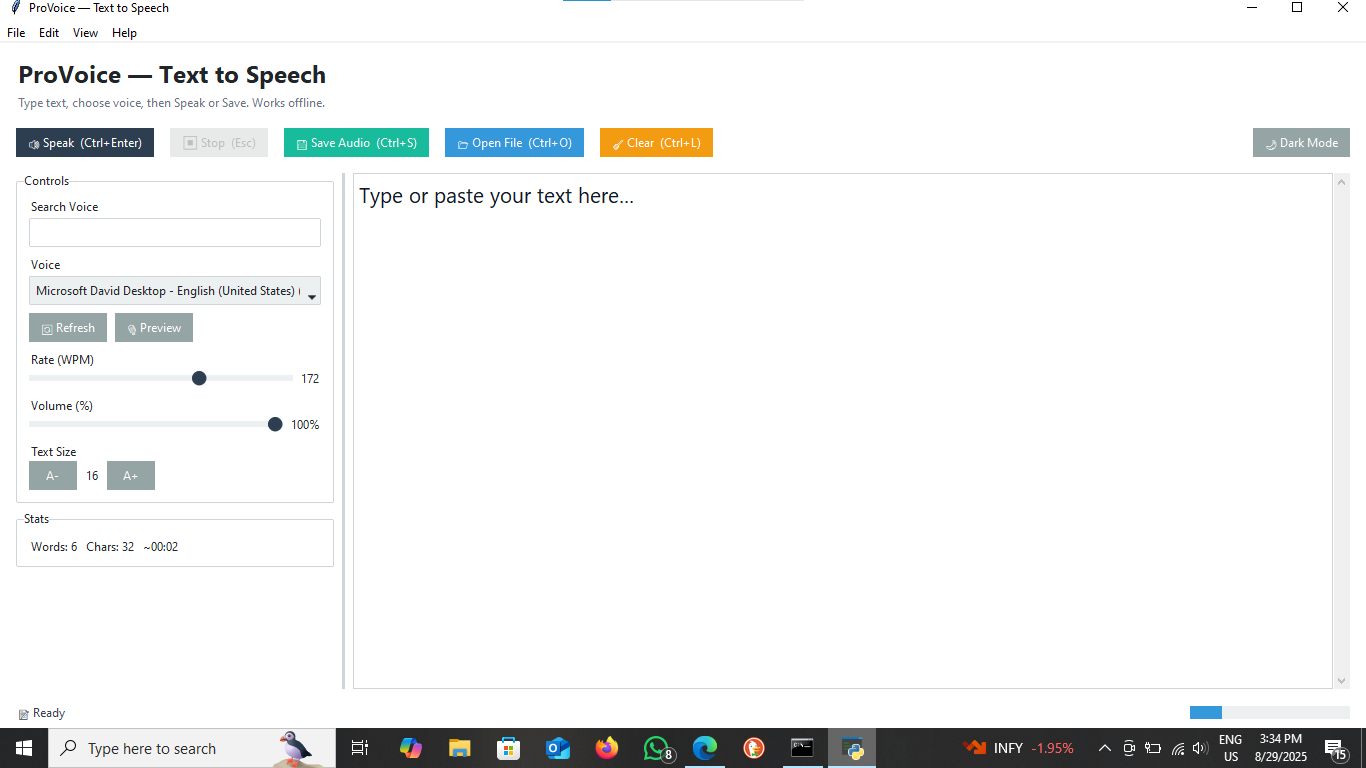